In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from PIL import Image

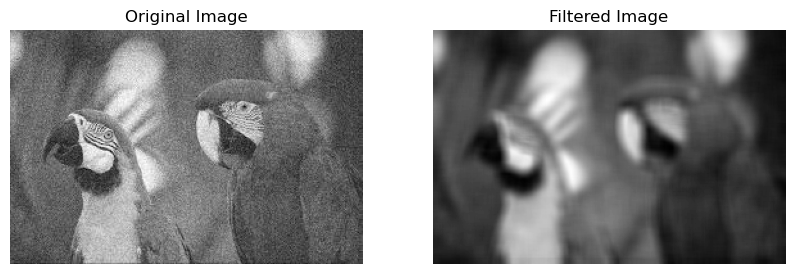

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    return np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(
            -((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)
        ),
        (size, size)
    )

def bilateral_filter(image, filter_size, sigma_s, sigma_b):
    height, width = image.shape
    pad = filter_size // 2
    padded_image = np.pad(image, pad, mode='reflect')
    output = np.zeros_like(image)
    
    spatial_kernel = gaussian_kernel(filter_size, sigma_s)
    
    for i in range(height):
        for j in range(width):
            i_padded, j_padded = i + pad, j + pad
            center_value = padded_image[i_padded, j_padded]
            
            # Extract local region
            local_region = padded_image[i_padded - pad:i_padded + pad + 1, j_padded - pad:j_padded + pad + 1]
            
            # Compute intensity difference
            intensity_diff = local_region - center_value
            
            # Compute range kernel
            range_kernel = np.exp(-(intensity_diff ** 2) / (2 * sigma_b ** 2))
            
            # Combine spatial and range kernels
            combined_kernel = spatial_kernel * range_kernel
            
            # Normalize the combined kernel
            combined_kernel /= combined_kernel.sum()
            
            # Compute the filtered value
            output[i, j] = np.sum(combined_kernel * local_region)
    
    return output

# Load and process image
image_path = 'image.jpg'
image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

# Adjust filter parameters
filter_size = 9
sigma_s = 75
sigma_b = 75  # Decrease this for less blurring

# Apply bilateral filter
filtered_image = bilateral_filter(image, filter_size, sigma_s, sigma_b)

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Filtered Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()


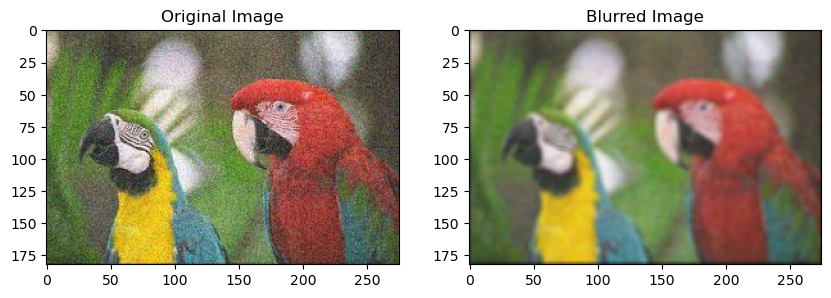

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    """Generate a Gaussian kernel"""
    kernel = np.fromfunction(
             lambda x, y: (1/(2*np.pi * sigma**2)) *
             np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2)/ (2 * sigma**2)),
             (size, size)
    )
    return kernel / np.sum(kernel)

def convolve(image, kernel):
    """Convolve a color image with a kernel"""
    kernel_height, kernel_width = kernel.shape
    image_height, image_width, channels = image.shape

    # Calculate the padding
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')

    output = np.zeros_like(image)

    # Convolution operation for each channel
    for c in range(channels):
        for i in range(image_height):
            for j in range(image_width):
                output[i, j, c] = np.sum(kernel * padded_image[i:i+kernel_height, j:j+kernel_width, c])

    return output

# Read the color image
image = cv2.imread('image.jpg')
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sigma = 4.0
kernel_size = 5

# Generate Gaussian kernel
kernel = gaussian_kernel(kernel_size, sigma)

# Apply Gaussian blur
blurred_image = convolve(image, kernel)

# Convert back to uint8
blurred_image = np.clip(blurred_image, 0, 255).astype(np.uint8)

# Save the result (convert back to BGR for OpenCV)
cv2.imwrite('blurred_image.jpg', cv2.cvtColor(blurred_image, cv2.COLOR_RGB2BGR))

# Display the original and blurred images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title('Blurred Image')
plt.imshow(blurred_image)
plt.show()

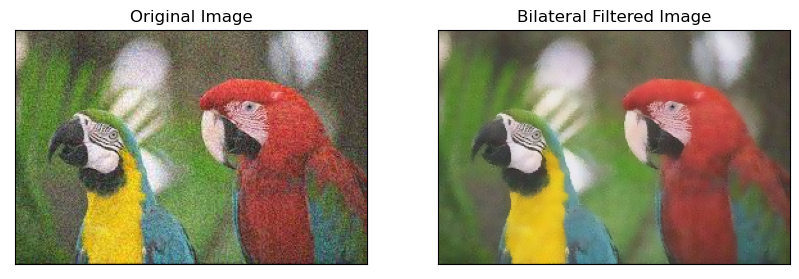

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load an image
img = cv2.imread('image.jpg')

# Apply bilateral filter
# Arguments: src, d, sigmaColor, sigmaSpace
# src: source image
# d: diameter of each pixel neighborhood that is used during filtering
# sigmaColor: filter sigma in the color space
# sigmaSpace: filter sigma in the coordinate space
bilateral_filtered_image = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bilateral_filtered_image_rgb = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2RGB)

# Plot the original and filtered images
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_rgb), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(bilateral_filtered_image_rgb), plt.title('Bilateral Filtered Image')
plt.xticks([]), plt.yticks([])

plt.show()


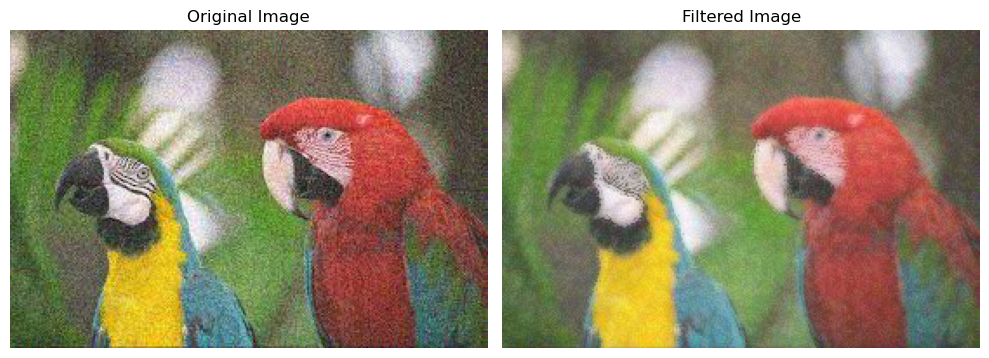

In [43]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numba import jit

@jit(nopython=True)
def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    return kernel / np.sum(kernel)

@jit(nopython=True)
def bilateral_filter_helper(padded_image, output, height, width, channels, filter_size, sigma_s, sigma_r):
    spatial_kernel = gaussian_kernel(filter_size, sigma_s)
    pad = filter_size // 2

    for i in range(height):
        for j in range(width):
            for c in range(channels):
                i_padded, j_padded = i + pad, j + pad
                center_value = padded_image[i_padded, j_padded, c]
                
                # Extract local region
                local_region = padded_image[i_padded - pad:i_padded + pad + 1, 
                                            j_padded - pad:j_padded + pad + 1, c]
                
                # Compute intensity difference
                intensity_diff = local_region - center_value
                
                # Compute range kernel
                range_kernel = np.exp(-(intensity_diff ** 2) / (2 * sigma_r ** 2))
                
                # Combine spatial and range kernels
                combined_kernel = spatial_kernel * range_kernel
                
                # Normalize the combined kernel
                combined_kernel /= np.sum(combined_kernel)
                
                # Compute the filtered value
                output[i, j, c] = np.sum(combined_kernel * local_region)

    return output

def bilateral_filter(image, filter_size, sigma_s, sigma_r):
    height, width, channels = image.shape
    pad = filter_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    output = np.zeros_like(image)
    
    return bilateral_filter_helper(padded_image, output, height, width, channels, filter_size, sigma_s, sigma_r)

# Load and process image
image_path = 'image.jpg'
image = np.array(Image.open(image_path).convert('RGB'))

# Adjust filter parameters
filter_size = 5  # Increased to match OpenCV's default
sigma_s = 75
sigma_r = 75  # This is equivalent to sigmaColor in OpenCV

# Apply bilateral filter
filtered_image = bilateral_filter(image, filter_size, sigma_s, sigma_r)

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Filtered Image')
plt.imshow(filtered_image.astype(np.uint8))
plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
import numpy as np
import cv2
import math

def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)

def gaussian(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))

def apply_bilateral_filter(source, filtered_image, x, y, diameter, sigma_i, sigma_s):
    hl = diameter // 2  # Use integer division to get half diameter
    i_filtered = 0
    Wp = 0
    i = 0
    while i < diameter:
        j = 0
        while j < diameter:
            neighbour_x = int(x - (hl - i))
            neighbour_y = int(y - (hl - j))
            if neighbour_x < 0:
                neighbour_x += len(source)
            if neighbour_y < 0:
                neighbour_y += len(source[0])
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])
            gi = gaussian(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)
            gs = gaussian(distance(neighbour_x, neighbour_y, x, y), sigma_s)
            w = gi * gs
            i_filtered += source[neighbour_x][neighbour_y] * w
            Wp += w
            j += 1
        i += 1
    i_filtered = i_filtered / Wp
    filtered_image[x][y] = int(round(i_filtered))


def bilateral_filter_own(source, filter_diameter, sigma_i, sigma_s):
    filtered_image = np.zeros(source.shape)

    i = 0
    while i < len(source):
        j = 0
        while j < len(source[0]):
            apply_bilateral_filter(source, filtered_image, i, j, filter_diameter, sigma_i, sigma_s)
            j += 1
        i += 1
    return filtered_image

# Example usage in Jupyter Notebook
src = cv2.imread("image.jpg", 0)
filtered_image_OpenCV = cv2.bilateralFilter(src, 5, 12.0, 16.0)
cv2.imwrite("image.jpg", src)
cv2.imwrite("filtered_image_OpenCV.png", filtered_image_OpenCV)
filtered_image_own = bilateral_filter_own(src, 5, 12.0, 16.0)
cv2.imwrite("filtered_image_own.png", filtered_image_own)


C:\Users\Ryzen\AppData\Local\Temp\ipykernel_7924\1818179106.py:29: RuntimeWarning: overflow encountered in ubyte_scalars
  gi = gaussian(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)


True